In [ ]:
# !pip install langchain_chroma pytube youtube-search youtube-transcript-api nest_asyncio wolframalpha

In [7]:
import os
import keyring
import warnings
warnings.filterwarnings('ignore')

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
WOFRAM_ALPHA_APPID = keyring.get_password('wolfram', 'key_for_windows')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['WOLFRAM_ALPHA_APPID'] = WOFRAM_ALPHA_APPID

In [ ]:
# Set async for using Woframlapha API

import asyncio
asyncio.set_event_loop_policy(asyncio.DefaultEventLoopPolicy())

import nest_asyncio
nest_asyncio.apply()

In [9]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
wolfram = WolframAlphaAPIWrapper()

In [10]:
# Set state including focus key value
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    focus: Literal["web", "academic", "video", "math"]

In [15]:
# define tools for web searching, retrieving articles, math calculation
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
import re

web_tool = TavilySearchResults(max_results=2)

@tool
def academic_tool(query: str):
    """ 
    academic papaer search tool
    """
    arxiv = ArxivAPIWrapper()
    docs = arxiv.run(query)
    return docs
    
@tool
def math_tool(query: str):
    """ 
    math tool
    """
    worlfram = WolframAlphaAPIWrapper()
    result = wolfram.run(query)
    return result

In [16]:
academic_tool.run("AI agent")

'Published: 2024-03-22\nTitle: CACA Agent: Capability Collaboration based AI Agent\nAuthors: Peng Xu, Haoran Wang, Chuang Wang, Xu Liu\nSummary: As AI Agents based on Large Language Models (LLMs) have shown potential in\npractical applications across various fields, how to quickly deploy an AI agent\nand how to conveniently expand the application scenario of AI agents has become\na challenge. Previous studies mainly focused on implementing all the reasoning\ncapabilities of AI agents within a single LLM, which often makes the model more\ncomplex and also reduces the extensibility of AI agent functionality. In this\npaper, we propose CACA Agent (Capability Collaboration based AI Agent), using\nan open architecture inspired by service computing. CACA Agent integrates a set\nof collaborative capabilities to implement AI Agents, not only reducing the\ndependence on a single LLM, but also enhancing the extensibility of both the\nplanning abilities and the tools available to AI agents. Utili

In [17]:
math_tool.run("123*123^2")

'Assumption: 123×123^2 \nAnswer: 1860867'

In [23]:
# define video search tool
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import YouTubeSearchTool
from langchain_community.document_loaders import YoutubeLoader
from langchain_core.documents import Document
import ast

youtube_search_tool = YouTubeSearchTool()

@tool
def video_tool(query:str) -> str:
    """ 
    Retrieve tool for the transcrript of Youtube video.
    If user want to find some information, this tool is to gather youtube video information.
    query should be given in string format.
    """
    try:
        # query에 해당하는 youtube 비디오 url 가져오기
        urls = youtube_search_tool.run(query)
        urls = ast.literal_eval(urls)
        # url 순회하면서 Document 객체에 내용 담기
        docs = []
        for url in urls:
            loader = YoutubeLoader.from_youtube_url(
                url,
                add_video_info=True,
                language=["en", "ko"]
            )
            scripts = loader.load()
            script_content = scripts[0].page_content
            title = scripts[0].metadata['title']
            author = scripts[0].metadata['author']
            doc = Document(page_content=script_content, metadata={"source":url, "title":title, "author":author})
            docs.append(doc)
            
        # 모든 비디오의 내용을 벡터DB에 담기
        text_splitter = RecursiveCharacterTextSplitter(
            separators = ["\n\n", "\n", ".", ",", " ", ""],
            chunk_size = 1000,
            chunk_overlap = 0
        )
        texts = text_splitter.split_documents(docs)
        
        # generate embeddings
        embeddings = OpenAIEmbeddings()
        db = Chroma.from_documents(texts, embeddings)
        retriever = db.as_retriever()
        
        # retrieved relevant docuements
        retrieved_docs = retriever.invoke(query)
        
        video_results = []
        for docs in retrieved_docs:
            title = doc.metadata.get('title', 'No title available')
            author = doc.metadata.get('author', 'No author available')
            script_content = doc.page_content
            
            video_info = f"""
            Video Information:
            ------------------
            Title: {title}
            Author: {author}
            Transcript:
            {script_content}
            """
            
            video_results.append(video_info)
            
        # join all video results into a single string
        all_video_results = "\n\n".join(video_results)
        
        return all_video_results
    
    except Exception as e:
        return f"An error occurred while retrieving video information: {e}"

In [25]:
video_tool.run("테디노트가 누구야?")

'An error occurred while retrieving video information: Exception while accessing title of https://youtube.com/watch?v=gcdkISrpMCA. Please file a bug report at https://github.com/pytube/pytube'

In [26]:
# Set tools into ToolNolde
tools = {
    "web": [web_tool],
    "academic": [academic_tool],
    "video": [video_tool],
    "math": [math_tool]
}

tool_nodes = {focus: ToolNode(tools[focus]) for focus in tools}

In [27]:
tool_nodes

{'web': tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}, tool_to_state_args={'tavily_search_results_json': {}}, tool_to_store_arg={'tavily_search_results_json': None}, handle_tool_errors=True, messages_key='messages'),
 'academic': tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'academic_tool': StructuredTool(name='academic_tool', description='academic papaer search tool', args_schema=<class 'langchain_core.utils.pydantic.academic_tool'>, func=<function academic_tool at 0x000001A01B235BD0>)}, tool_to_state_args={'academic_tool': {}}, tool_to_store_arg={'academic_tool': None}, handle_tool_errors=True, messages_key='messages'),
 'video': tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={

In [28]:
# Setting Chatbot
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

def chatbot(state: State):
    llm_with_tools = llm.bind_tools(tools[state['focus']])
    result = llm_with_tools.invoke(state['focus'])
    return {"messages": [result]}

In [30]:
# build a grapg
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

for focus, tool_node in tool_nodes.items():
    graph_builder.add_node(f"{focus}_tools", tool_node)
    
def focus_condition(state):
    if state["messages"][-1].tool_calls:
        return f"{state['focus']}_tools"
    return END      # END 상수 사용

graph_builder.add_conditional_edges(
    "chatbot",
    focus_condition,
    {
        "web_tools": "web_tools",
        "academic_tools": "academic_tools",
        "video_tools": "video_tools",
        "math_tools": "math_tools",
        END: END
    }
)

for focus in tools:
    graph_builder.add_edge(f"{focus}_tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

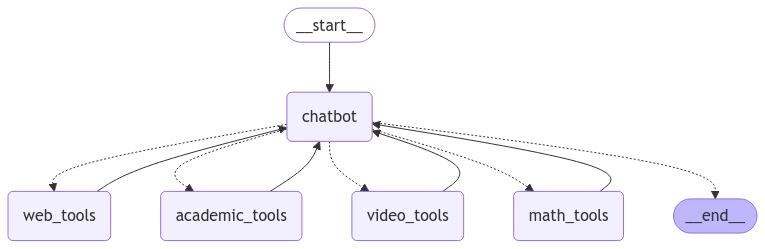

In [31]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
# example with multiple tool calls in succestion

for chunk in graph.stream({
    "messages": [{"role": "user", "content": "AI 에이전트에는 어떤 프레임워크가 있어?"}],
    "focus": "academic"
}, stream_mode="values"):
    print(chunk['messages'][-1].content)

AI 에이전트에는 어떤 프레임워크가 있어?

Published: 2021-11-26
Title: Academic Lobification: Low-performance Control Strategy for Long-planed Academic Purpose
Authors: Shudong Yang
Summary: Academic lobification refers to a collection of academic performance control
strategies, methods, and means that a student deliberately hides academic
behaviors, or deliberately lowers academic performance, or deliberately delays
academic returns for a certain long-term purpose, but does not produce academic
risks. Understanding academic lobification is essential to our ability to
compensate for inherent deviations in the evaluation of students' academic
performance, discover gifted student, reap benefits and minimize harms. It
outlines a set of questions that are fundamental to this emerging
interdisciplinary research field, including research object, research question,
research scope, research method, and explores the technical, legal and other
constraints on the study of academic lobification.

Published: 2018-0